<a href="https://colab.research.google.com/github/austinbennysmith/OSOM-ERDDAP/blob/master/MODIS_%26_VIIRS_Faster_Comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this notebook, I will:**
*   Graph the average of chlorophyll a or the diffuse attenuation coefficient at 490 nm (k490) against time
*   Make a monthly climatology for chlorophyll a or k490
*   Graph the anomalies of chlorophyll a or k490 against time (climatology subtracted from the values)

This code allows the Suomi-NPP/VIIRS data and the MODIS data to be graphed together and compared.

This notebook works with datasets on the [RIDDC ERDDAP server](https://pricaimcit.services.brown.edu/erddap/index.html) that were produced by the MODIS and Suomi-NPP/VIIRS instruments.

First, Colab requires some installations and imports:

In [ ]:
!pip install netCDF4
import requests
from netCDF4 import Dataset as NetCDFFile
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#To use cartopy in a Colab notebook, I need a particular sequence of installs (as shown at this notebook: https://colab.research.google.com/github/adamlamee/CODINGinK12/blob/master/notebooks/quakes.ipynb#scrollTo=3LkZkXvnMAr4)
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;
!pip install shapely --no-binary shapely;
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import calendar
import datetime

In the following cell, I **graph the spatial average of chlorophyll a or k490 against time**. This can be done fairly quickly for either variable at Monthly, 8 Day or 1 Day resolution. You can also manipulate which years are graphed by changing the dates listed where MODIS_start_date, MODIS_end_date, VIIRS_start_date, and VIIRS_end_date are defined. Note that MODIS data goes back to 2003, while VIIRS data only goes back to 2012. If you run the code, it will ask you which variable to graph and at what resolution. Additionaly, this code allows you to play with the scaling between the two types of data. For some reason, MODIS tends to detect larger values for chlorophyll a and k490 than VIIRS. It is likely that the VIIRS data is more accurate, so below I show an unscaled version of the graph, as well as one in which the MODIS data is scaled by 0.75 to better match VIIRS.

Would you like to graph Chlorophyll or k490?Chlorophyll
Monthly, 8 Day, or 1 Day Composite?8 Day
https://pricaimcit.services.brown.edu/erddap/griddap/erdMH1chla8day.nc?chlorophyll[(2011-01-05):1:(2013-01-05)][(41.5):1:(40.5)][(-72.65):1:(-70.25)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in greater


https://pricaimcit.services.brown.edu/erddap/griddap/erdVH2018chla8day.nc?chla[(2012-01-05):1:(2013-01-05)][(41.5):1:(40.5)][(-72.65):1:(-70.25)]


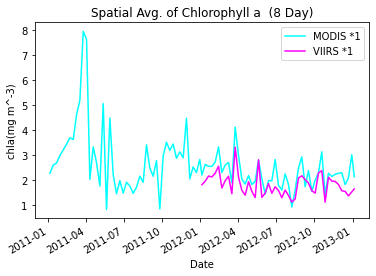

https://pricaimcit.services.brown.edu/erddap/griddap/erdMH1chla8day.nc?chlorophyll[(2011-01-05):1:(2013-01-05)][(41.5):1:(40.5)][(-72.65):1:(-70.25)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in greater


https://pricaimcit.services.brown.edu/erddap/griddap/erdVH2018chla8day.nc?chla[(2012-01-05):1:(2013-01-05)][(41.5):1:(40.5)][(-72.65):1:(-70.25)]


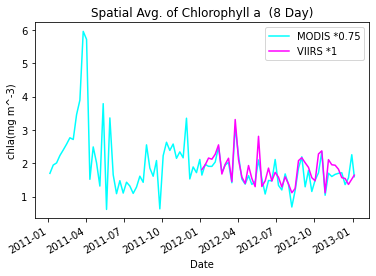

In [ ]:
#To save images, I mount Google Drive:
#from google.colab import drive
#drive.mount('/content/gdrive')
#images_dir = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/OSOM_Satellite Comparisons/Satellite Observations'
from datetime import datetime as dt
from datetime import date
#Modis dataset IDs: 'erdMH1chla1day', 'erdMH1chla8day', 'erdMH1chlamday', 'erdMH1kd4901day', 'erdMH1kd4908day', 'erdMH1kd490mday', 'erdMH1par01day', 'erdMH1par08day', 'erdMH1par0mday'
#VIIRS dataset IDs: 'erdVH2018chla8day', 'erdVH2018chla1day', 'erdVH2018chlamday', 'erdVH2018k4908day', 'erdVH2018k4901day', 'erdVH2018k490mday', 'erdVH2018par8day', 'erdVH2018par1day', 'erdVH2018parmday'
#For monthly composites:
variable = input('Would you like to graph Chlorophyll or k490?')
tres = input('Monthly, 8 Day, or 1 Day Composite?')
#I use the input to decide which dictionary of dataset IDs to loop through as I produce the graphs:
if tres == 'Monthly':
  monthly_data_dict = {
      'Chlorophyll':['erdMH1chlamday', 'erdVH2018chlamday'],
      'k490':['erdMH1kd490mday', 'erdVH2018k490mday']
  }
elif tres == '8 Day':
  monthly_data_dict = {
      'Chlorophyll':['erdMH1chla8day', 'erdVH2018chla8day'],
      'k490':['erdMH1kd4908day', 'erdVH2018k4908day']
  }
elif tres == '1 Day':
  monthly_data_dict = {
      'Chlorophyll':['erdMH1chla1day', 'erdVH2018chla1day'],
      'k490':['erdMH1kd4901day', 'erdVH2018k4901day']
  }
#I use the dataset IDs dictionary to define the variable tt, which is used later on for things like labeling graphs
if '1day' in monthly_data_dict['Chlorophyll'][0]:
  tt = '1 Day'
elif '8day' in monthly_data_dict['Chlorophyll'][0]:
  tt = '8 Day'
elif 'mday' in monthly_data_dict['Chlorophyll'][0]:
  tt = 'Monthly'
timearray = []
#The following scaleslist will be looped through to produce graphs with 2 different scalings between the VIIRS and MODIS data. Multiplying MODIS numbers by 0.75 should provide a decent fit.
scaleslist = [1, 0.75]
#For the monthly composites, MODIS start day is 2003-01-16 and end is 2020-05-15; VIIRS start is 2012-01-16 and end is 2020-05-16 (end dates change as dataset is added to)
#For the 8 day composites, MODIS start day is 2003-01-05 and end is 2020-06-29; VIIRS start is 2012-01-05 and end is 2020-06-29 (end dates will change as the dataset is continually added to)
#For the 1 day composites, MODIS start day is 2003-01-01 at 12:00:00 and end day is 2020-07-21 at 12:00:00, VIIRS start day is 2012-01-02 at 12:00:00 and end is 2020-07-20 at 12:00:00 (for the monthly and 8 day composites, the time is always 00:00:00 while for the 1 day it is 12:00:00)
#You can change the dates below to graph different time ranges
MODIS_start_date = date(2011, 1, 5)
MODIS_end_date = date(2013, 1, 5)
VIIRS_start_date = date(2012, 1, 5)
VIIRS_end_date = date(2013, 1, 5)
#All of the graphing is done in a loop through scaleslist so you get graphs for each scaling you want to try
for scaleyscales in scaleslist:
  #The following 2 lines rotate the dates on the x axis if necessary to make it easier to read. Depending on what you're trying to graph, these lines could be commented out
  fig, ax = plt.subplots()
  fig.autofmt_xdate()
  #The following for loop allows you to make plots for both MODIS & VIIRS on the same axes. monthly_data_dict is a dictionary whose elements are lists of dataset IDs, and for each dataset ID you're making a graph
  for k in monthly_data_dict[variable]:#k is a dataset ID
    #These conditional statements set up variables used in the plots later on & in generating a url from which I'll get the data
    if variable == 'Chlorophyll':
      if 'MH' in k:#k is a dataset ID
        myvar = 'chlorophyll'
        start_date = MODIS_start_date
        end_date = MODIS_end_date
        thecolor = 'cyan'
        satellite = 'MODIS '
        scale = scaleyscales
        mhscale = scaleyscales
      elif 'VH' in k:
        myvar = 'chla'
        start_date = VIIRS_start_date
        end_date = VIIRS_end_date
        satellite = 'VIIRS '
        thecolor = 'magenta'
        scale = 1
      unit = 'mg m^-3'
      title = 'Chlorophyll a '
    elif variable == 'k490':
      if 'MH' in k:
        myvar = 'k490'
        satellite = 'MODIS '
        start_date = MODIS_start_date
        end_date = MODIS_end_date
        thecolor = 'cyan'
        scale = scaleyscales
        mhscale = scaleyscales
      elif 'VH' in k:
        myvar = 'k490'
        satellite  = 'VIIRS '
        start_date = VIIRS_start_date
        end_date = VIIRS_end_date
        thecolor = 'magenta'
        scale = 1
      unit = 'm^-1'
      title = 'K490 '
    url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+k+'.nc?'+myvar+'[('+str(start_date)+'):1:('+str(end_date)+')][(41.5):1:(40.5)][(-72.65):1:(-70.25)]'
    print(url)
    r = requests.get(url, allow_redirects=True)
    open('test.nc', 'wb').write(r.content)
    nc = NetCDFFile('test.nc')
    nc
    #Defining data variables:
    lat = nc.variables['latitude'][:]
    lon = nc.variables['longitude'][:]
    time = nc.variables['time'][:]
    #making a list of times to make graphing easier:
    timearray = []
    for i in time:
      timearray.append(dt.fromtimestamp(i))
    mapvar = nc.variables[myvar][:]
    #taking the average over both latitude & longitude:
    #By the way, you can find out which axes the variables are at by importing xarray and doing xr.open_dataset('test.nc') instead of using NetCDFFile, then typing print(nc.dims). That should give you the dimensions in the correct order, so that you know which axes to average over
    mapvar = mapvar.mean(axis = tuple(range(1,3)))
    plt.plot(timearray, mapvar*scale, color = thecolor, label = satellite+'*'+str(scale))
  #For years that MODIS has but VIIRS doesn't (such as 2006), simply add an indent to the following lines. So it will plot & save the figure for MODIS, and only throw an error afterwards when it loops to VIIRS
  plt.legend(loc='best')
  plt.title('Spatial Avg. of '+title+' ('+tt+')')
  plt.xlabel('Date')
  plt.ylabel(myvar+'('+unit+')')
  #Saving the image:
  #plt.savefig(f"{images_dir}/"+tt+" "+myvar+" with scale factor of "+str(mhscale)+" time series "+str(MODIS_start_date)+' to '+str(MODIS_end_date)+".png")
  plt.show()

Next, I graph a **climatology of chlorophyll a or k490**. This only does a monthly climatology. Like before, this code allows:


*   changing which years you're graphing via the start_date and end_date variables
*   graphing with a bunch of different scale factors for MODIS by looping through scaleslist





Would you like to graph Chlorophyll or k490?Chlorophyll


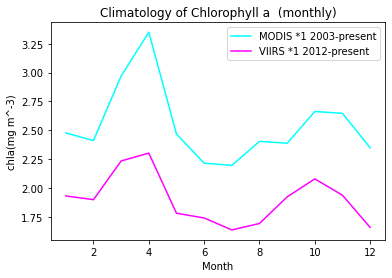

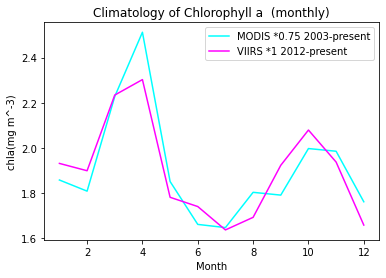

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#images_dir = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages/MODIS_VIIRS_COMPARISONS_NEW/Correct Coordinates'
from datetime import datetime as dt
from datetime import date, timedelta
#For the climatology, I open the dataset using xr.open_dataset() instead of NetCDFFile as in previous code cells, because xarray allows me to more easily split up the dataset by month using the nc.sel function
import pandas as pd
import xarray as xr
#Only one monthly_data_dict needed for this since it's only monthly (in the previous cell I needed to choose which version of monthly_data_dict based on whether it was monthly, 8 Day,  or 1 Day data)
monthly_data_dict = {
    'Chlorophyll':['erdMH1chlamday', 'erdVH2018chlamday'],
    'k490':['erdMH1kd490mday', 'erdVH2018k490mday']
}
variable = input('Would you like to graph Chlorophyll or k490?')
tt = 'monthly'
timearray = []
monthlist = []
#Need to create a list of months for plotting later:
for mymonth in range(1,13):
  monthlist.append(mymonth)
#the following line allows me to loop through a bunch of different scale factors & decide which one seems to work the best.
scaleslist = [1, 0.75]
#loop through scaleslist
for scaleyscales in scaleslist:
  #loop through dataset IDs associated with either Chlorophyll or k490, depending on input:
  for k in monthly_data_dict[variable]:
    months_dict = {}
    if variable == 'Chlorophyll': #k will be a loop variable when I make the for loop later
      #These conditional statements set up variables used in the plots later on & in generating a url from which I'll get the data
      if 'MH' in k:
        myvar = 'chlorophyll'
        start_date = date(2003, 1, 16) #can change this & end_date depending on what you want to graph
        end_date = date(2020, 5, 16)
        thecolor = 'cyan'
        satellite = 'MODIS '
        scale = scaleyscales
        mhscale = scaleyscales
        timerange = ' 2003-present'
      elif 'VH' in k:
        myvar = 'chla'
        start_date = date(2012, 1, 15)
        end_date = date(2020, 4, 15)
        satellite = 'VIIRS '
        thecolor = 'magenta'
        scale = 1
        timerange = ' 2012-present'
      unit = 'mg m^-3'
      title = 'Chlorophyll a '
    elif variable == 'k490':
      if 'MH' in k:
        myvar = 'k490'
        satellite = 'MODIS '
        start_date = date(2003, 1, 16)
        end_date = date(2020, 5, 16)
        thecolor = 'cyan'
        scale = scaleyscales
        mhscale = scaleyscales
        timerange = ' 2003-present'
      elif 'VH' in k:
        myvar = 'k490'
        satellite  = 'VIIRS '
        start_date = date(2012, 1, 15)
        end_date = date(2020, 4, 15)
        thecolor = 'magenta'
        scale = 1
        timerange = ' 20012-present'
      unit = 'm^-1'
      title = 'K490 '
    #make a url, open the netcdf file:
    url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+k+'.nc?'+myvar+'[('+str(start_date)+'):1:('+str(end_date)+')][(41.5):1:(40.50)][(-72.65):1:(-70.25)]'
    r = requests.get(url, allow_redirects=True)
    open('test.nc', 'wb').write(r.content)
    #using the .load() at the end below, and then typing nc.close, helps prevent some errors
    nc = xr.open_dataset('test.nc').load()
    nc.close()
    #the following for loop makes a list of 12 lists, using the .sel function to divide up the data by month. This is why I use xarray for this cell
    for j in range(1,13):
      months_dict[str(j)] = nc.sel(time=nc['time.month']==j) #then I think if I do average with axis=0 for each of these sublists, it'll be able to produce a climatological movie. Possible extension of this for the future
    graphinglist = []
    #now that I have list for each month, I can simply take an average of all the values in each month's list to get 12 data points that will be graphed as the monthly climatology. Shown below.
    for y in months_dict:
      graphinglist.append(scale*float(months_dict[y].variables[myvar].mean()))
    plt.plot(monthlist, graphinglist, color = thecolor, label = satellite+'*'+str(scale)+timerange)
  plt.legend(loc='best')
  plt.title('Climatology of '+title+' ('+tt+')')
  plt.xlabel('Month')
  plt.ylabel(myvar+'('+unit+')')
  #plt.savefig(f"{images_dir}/"+tt+" "+myvar+" with scale factor of "+str(mhscale)+" climatoloty.png")
  plt.show()

Finally, I graph the **anomalies of chlorophyll a or k490 over time**, again allowing adjustments for time range and MODIS scale factor. This is just a slightly adjusted version of the monthly climatology code (and again, this code only works for monthly data). Here I'm only showing the anomalies with a scale factor of 1 for MODIS.

Would you like to graph Chlorophyll or k490?Chlorophyll


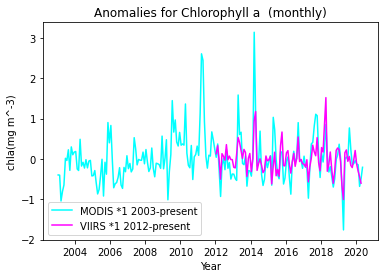

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#images_dir = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages/MODIS_VIIRS_COMPARISONS_NEW/Correct Coordinates'
from datetime import datetime as dt
from datetime import date, timedelta
#again, I'm using xarray.open_dataset() instead of NetCDFFile, because xarray allows me to more easily split up the dataset by month using the nc.sel function
import xarray as xr
import pandas as pd
monthly_data_dict = {
    'Chlorophyll':['erdMH1chlamday', 'erdVH2018chlamday'],
    'k490':['erdMH1kd490mday', 'erdVH2018k490mday']
}
variable = input('Would you like to graph Chlorophyll or k490?')
tt = 'monthly'
timearray = []
monthlist = []
#Need to create a list of months for plotting later:
for mymonth in range(1,13):
  monthlist.append(mymonth)
#the following line allows me to loop through a bunch of different scale factors & decide which one seems to work the best.
scaleslist = [1]
#looping through scales
for scaleyscales in scaleslist:
  #looping through 2 dataset IDs
  for k in monthly_data_dict[variable]:
    #I create a months_dict dictionary whose keys are month numbers and whose values are lists of data specific to that month. I will create it using a for loop later on, so I start with the empty dictionary below.
    months_dict = {}
    #defining things with conditionals for url/graphing purposes:
    if variable == 'Chlorophyll': #k will be a loop variable when I make the for loop later
      if 'MH' in k:
        myvar = 'chlorophyll'
        start_date = date(2003, 1, 16)
        end_date = date(2020, 5, 16)
        thecolor = 'cyan'
        satellite = 'MODIS '
        scale = scaleyscales
        mhscale = scaleyscales
        timerange = ' 2003-present'
      elif 'VH' in k:
        myvar = 'chla'
        start_date = date(2012, 1, 15)
        end_date = date(2020, 4, 15)
        satellite = 'VIIRS '
        thecolor = 'magenta'
        scale = 1
        timerange = ' 2012-present'
      unit = 'mg m^-3'
      title = 'Chlorophyll a '
    elif variable == 'k490':
      if 'MH' in k:
        myvar = 'k490'
        satellite = 'MODIS '
        start_date = date(2003, 1, 16)
        end_date = date(2020, 5, 16)
        thecolor = 'cyan'
        scale = scaleyscales
        mhscale = scaleyscales
        timerange = ' 2003-present'
      elif 'VH' in k:
        myvar = 'k490'
        satellite  = 'VIIRS '
        start_date = date(2012, 1, 15)
        end_date = date(2020, 4, 15)
        thecolor = 'magenta'
        scale = 1
        timerange = ' 20012-present'
      unit = 'm^-1'
      title = 'K490 '
    #creating a url, opening it using xr.open_dataset()
    url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+k+'.nc?'+myvar+'[('+str(start_date)+'):1:('+str(end_date)+')][(41.5):1:(40.50)][(-72.65):1:(-70.25)]' #this won't match earlier graphs because I changed the coordinates
    r = requests.get(url, allow_redirects=True)
    open('test.nc', 'wb').write(r.content)
    #using the .load at the end of xr.open_dataset and then typing nc.close prevents some errors:
    nc = xr.open_dataset('test.nc').load()
    nc.close()
    mapvar = nc.variables[myvar][:]
    #The following for loop divides up the netcdf by month, the xarray function .sel
    for j in range(1,13):
      months_dict[str(j)] = nc.sel(time=nc['time.month']==j)
    #next, I take the average of mapvar (chlorophyll or k490, depending on the input) for each month and append that average to graphinglist, yielding a graphinglist with 12 elements that represents the climatology.
    graphinglist = []
    for y in months_dict:
      graphinglist.append(float(months_dict[y].variables[myvar].mean()))
    #next, I calculate the anomalies by creating an empty anomalieslist, and then looping through the time variable in nc. At each time point in nc, I calculate the spatial average and subtract from it the corresponding entry in graphinglist (which represents the climatoloty). This yields the anomaly, and the code appends the anomalies to anomalieslist, which can be graphed.
    anomalieslist = []
    for z in nc['time']:
      #in the following line I pick the point in nc that corresponds to the current time point in the loop, and call that todays_chla
      todays_chla = nc.sel(time=nc['time']==z)
      #I need a variable representing todays_month so I can subtract the correct entry in graphinglist from todays_chla
      todays_month = int(z['time.month'])
      #the following line takes the average at the current time point
      todays_chla_mean = todays_chla.mean(axis = tuple(range(1,3))) #this is where I could change the program to generate anomalies at each gridpoint. Instead of averaging over time, I could simply subtract the climatology for each point here (the climatology would have been calculated earlier by not averaging over space)
      anomalieslist.append(todays_chla_mean - graphinglist[todays_month-1])
    anomalies_for_graphing = []
    #the following allows for scaling (given the conditionals above, the scale will be 1 for VIIRS data but potentially something else for MODIS, depending on what numbers you put in scaleslist)
    for n in anomalieslist:
      anomalies_for_graphing.append(float(n[myvar])*scale)
    plt.plot(nc['time'], anomalies_for_graphing, color = thecolor, label = satellite+'*'+str(scale)+timerange) #add scale factor here once I've added in that feature
  plt.legend(loc='best')
  plt.title('Anomalies for '+title+' ('+tt+')')
  plt.xlabel('Year')
  plt.ylabel(myvar+'('+unit+')')
  #plt.savefig(f"{images_dir}/"+tt+" "+myvar+" with scale factor of "+str(mhscale)+"anomalies time series.png")
  plt.show()